In [1]:
cd ..

/Users/ravithakur/Documents/Study/ML,DL Implementations/MLDL


/Users/ravithakur/Library/Caches/pypoetry/virtualenvs/mlimpl-TsLQh6uh-py3.12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from recommender_sys.als import ALSNumExpl
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import the dataset
df = pd.read_csv('datasets/movielens100k.csv')
df.head()

,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [4]:
scaler = MinMaxScaler()

# Fit and transform the 'rating' column
df['rating_scaled'] = scaler.fit_transform(df[['rating']])
df.head()

,userID,itemID,rating,timestamp,rating_scaled
0,196,242,3.0,881250949,0.50
1,186,302,3.0,891717742,0.50
2,22,377,1.0,878887116,0.00
3,244,51,2.0,880606923,0.25
4,166,346,1.0,886397596,0.00


In [5]:
ratings = csr_matrix((df.rating.values, (df.userID, df.itemID)))

In [26]:
seed = 42
np.random.seed(seed)

In [27]:
ulf = np.random.rand(ratings.shape[0], 100)*0.001
ilf = np.random.rand(ratings.shape[1], 100)*0.001

regular = 0.01

Now the main calculation

$$
\begin{equation}
    \begin{aligned}
        \mathbf{u}_i &= (\sum_{j=1}^m\mathbf{v}_j\mathbf{v}_j^T + \lambda)^{-1}\sum_{j=1}^mR_{ij}\mathbf{v}_j \\
        \mathbf{v}_j &= (\sum_{i=1}^n\mathbf{u}_i\mathbf{u}_i^T + \lambda)^{-1}\sum_{i=1}^n R_{ij}\mathbf{u}_i
    \end{aligned}
\end{equation}
$$

Since the above requires the calculation of inverses of square matrices of size $k \times k$, we would first prioritize calculating inverses of the matrix $\sum_{j=1}^m\mathbf{v}_j\mathbf{v}_j^T + \lambda$. We also need to figure out how to compute $\mathbf{v}_j\mathbf{v}_j^T$. The above equations can be written in the form of $\mathbf{u}_i = \mathbf{A}^{-1}\mathbf{b}$ We compute the two separately

In [8]:
# Computing vv^T square matrix

"""
uu^T = [u_1, u_2, u_3][u_1 
                       u_2
                       u_3]
"""
def A_inv(mat, regular):
    uut = np.einsum('ij,ik->jk', mat, mat)
    return np.linalg.inv(uut + regular*np.eye(uut.shape[0]))

def get_B(ratings, lf_matrix, index, method='row'):
    if method == 'col':
        ratingW = ratings.getcol(index).A.flatten()
    else:
        ratingW = ratings.getrow(index).A[0]
    return np.dot(ratingW, lf_matrix)


Now we can create each step of the ALS inner iteration. Next we also want to store the losses in each iteration
the overall loss can be the RMSE for the non-zero user-item ratings. The loss function is given as

$$
\begin{equation*}
\begin{aligned}
    L(\mathbf{U}, \mathbf{V}) &= \frac{1}{2}\sum_{(i,j) \in \mathbf{R}} (R_{ij} - \mathbf{u}_i^T \cdot \mathbf{v}_j)^2 + \frac{\lambda}{2} \left[\sum_{i=1}^n ||\mathbf{u}_i||_2^2 + \sum_{j=1}^m ||\mathbf{v}_j||_2^2\right] \\
    &= \frac{1}{2}\sum_{(i,j) \in \mathbf{R}} (R_{ij} - \mathbf{u}_i^T \cdot \mathbf{v}_j)^2 + \frac{\lambda}{2} \left[\sum_{i=1}^n \mathbf{u}_i^T \cdot \mathbf{u}_i + \sum_{j=1}^m \mathbf{v}_j^T \cdot \mathbf{v}_j \right]
\end{aligned}
\end{equation*}
$$


In [9]:
rows, columns = ratings.nonzero()

In [10]:
def loss_als(ratings, rows, columns, users, items, regular):
    actual_ratings = ratings.data

    # Compute predictions for all non-zero entries
    predictions = np.sum(users[rows] * items[columns], axis=1)

    # Calculate the squared differences
    squared_diff = (actual_ratings - predictions)**2

    # frobenius norm of user and item latent matrices
    fro_user = np.linalg.norm(users, ord='fro')**2
    fro_item = np.linalg.norm(items, ord='fro')**2

    # Compute the loss
    loss = 0.5*(np.sum(squared_diff) + regular*(fro_user + fro_item))
    return loss



In [11]:
loss_als(ratings, rows, columns, ulf, ilf, regular)

686343.1899860945

TODO

1. Optimize Single outer iteration - updations of user and item matrices
2. Setup, Run and Analyse results on pyspark ALS.

In [28]:
# Optimizing single outer iteration

losses = []
regular = 0.01
rows, columns = ratings.nonzero()

for iteration in tqdm(range(100)):
    # first update user matrix
    a_inv = A_inv(ilf, regular)
    B = ratings.dot(ilf)
    ulf = B @ a_inv.T
    
    # update item matrix
    a_inv = A_inv(ulf, regular)
    B = ratings.transpose().dot(ulf)
    ilf = B @ a_inv.T

    iteration_loss = loss_als(ratings, rows, columns, ulf, ilf, regular)
    losses.append(iteration_loss)

100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


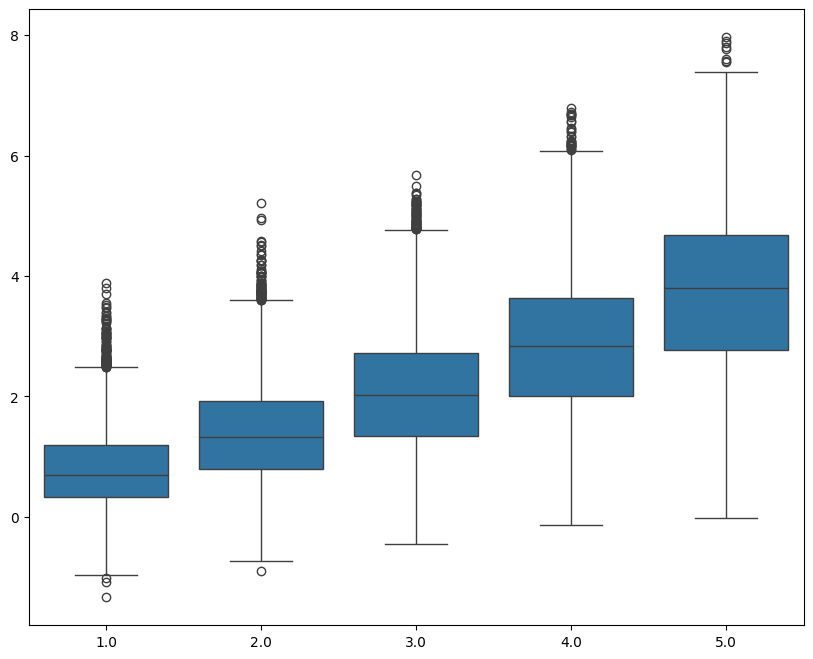

In [29]:
# Let's try to plot the predicted and actual ratings
actual_ratings = ratings.data
predictions = np.sum(ulf[rows] * ilf[columns], axis=1)

plt.figure(figsize=(10,8))
# plt.scatter(actual_ratings[:1000], predictions[:1000], alpha=0.3)
sns.boxplot(x=actual_ratings, y=predictions)
plt.show()

In [17]:
# Next we test the implemented module

als = ALSNumExpl(ratings=ratings, factors=100, regularization=0.01, seed=42)
als_losses = als.fit(iterations=100)

100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


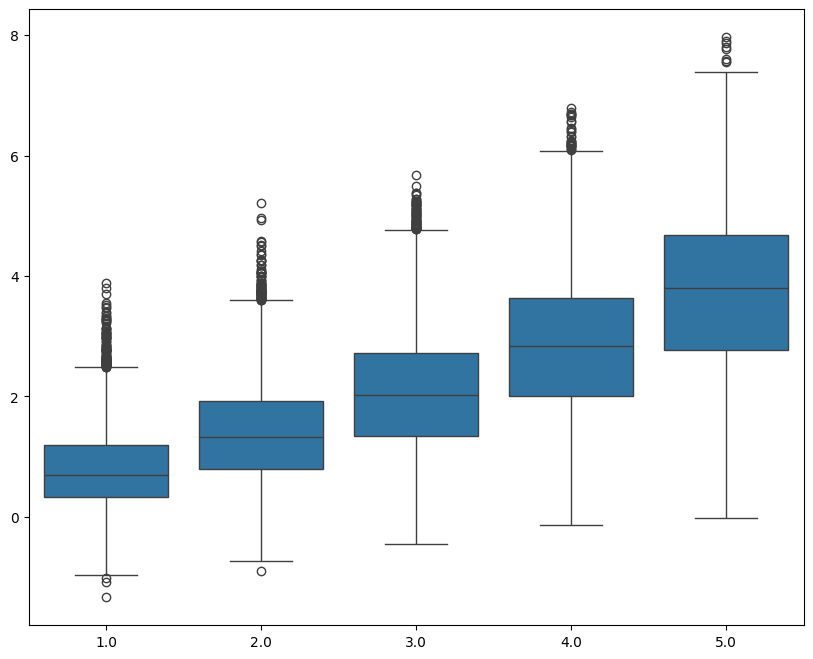

In [15]:
actual_ratings = als.ratings.data
rows, columns = als.ratings.nonzero()
predictions = np.sum(als.ulf[rows] * als.ilf[columns], axis=1)

plt.figure(figsize=(10,8))
sns.boxplot(x=actual_ratings, y=predictions)
plt.show()

In [31]:
losses[0] == als_losses[1]

True

In [32]:
losses[-1] == als_losses[-1]

True